In [82]:
# Dependencies
import pandas as pd
from scipy.io import loadmat
import glob
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import LSTM,Dropout,Dense 
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
from tqdm import tqdm
import tensorflow as tf


ImportError: cannot import name 'Adam' from 'keras.optimizers' (/usr/local/lib/python3.9/site-packages/keras/optimizers.py)

## Step 1: Load the data.
Class has 3 elements
- An ```__init__``` function that sets up your class and all the necessary parameters.
- An ```__len__``` function that returns the size of your dataset.
- An ```__getitem__``` function that given an index within the limits of the size of the dataset returns the associated image and label in tensor form.

In [2]:
# folder names
dc_folders = ['Europe', 'Japan', 'USA']

# Implement the dataset class
class DrivingCyclesDataset(Dataset):
    def __init__(self,
                 path_to_dc,
                 train=True):
        # path_to_dc: where you put the driving cycles dataset
        # idxs_train: training set indexes
        # idxs_test: test set indexes
        # train: return training set or test set
        
        # Load all the driving cycles
        alldata = []
        dcnames = []
        if (train == True):
            mat = loadmat('./DrivingCycles/WLTPextended.mat')
            df = pd.DataFrame(mat['V_z'], columns = ['V_z']) # velocity 
            df2 = pd.DataFrame(mat['T_z'], columns = ['T_z']) # time
            df3 = pd.DataFrame(mat['D_z'], columns = ['D_z']) # acceleration
            df = pd.concat([df, df2, df3], axis=1)
            alldata.append(df)
            dcnames.append('WLTPextended.mat')
            for folder in dc_folders:
                image_path = os.path.join(path_to_dc, folder)
                files = glob.glob(image_path + '/*.mat')
                for f in files:
                    mat = loadmat(f)
                    df = pd.DataFrame(mat['V_z'], columns = ['V_z'])
                    df2 = pd.DataFrame(mat['T_z'], columns = ['T_z'])
                    df3 = pd.DataFrame(mat['D_z'], columns = ['D_z'])
                    df = pd.concat([df, df2, df3], axis=1)
                    dcnames.append(os.path.basename(f))
                    # each dataframe is a driving cycle 
                    alldata.append(df)
            # Extract the driving cycles with the specified file indexes     
            self.data = (np.array(alldata, dtype=object))[p] #numpy array of dataframes 
            self.names = (np.array(dcnames, dtype=object))[p]
        
        else:
            image_path = os.path.join(path_to_dc, 'test')
            files = glob.glob(image_path + '/*.mat')
            for f in files:
                mat = loadmat(f)
                df = pd.DataFrame(mat['V_z'], columns = ['V_z'])
                df2 = pd.DataFrame(mat['T_z'], columns = ['T_z'])
                df3 = pd.DataFrame(mat['D_z'], columns = ['D_z'])
                df = pd.concat([df, df2, df3], axis=1)
                dcnames.append(os.path.basename(f))
                # each dataframe is a driving cycle 
                alldata.append(df)

            self.data = alldata
            self.names = dcnames


    def __len__(self, idx):
        # Return the number of samples in a driving cycle 
        return (self.data[idx]).size
        
    def __getitem__(self, idx):
        # Get an item using its index
        # Return the driving cycle and its name 
        return self.data[idx]

In [3]:
def split_train_test(lendata, percentage=0.8):
    idxs_train = int(percentage * lendata)
    idxs_test = idxs_train + 1 
    return idxs_train, idxs_test

LENDATA = 36 + 6 + 4 + 1 # number of driving cycles = 47
np.random.seed(42)
idxs_train, idxs_test = split_train_test(LENDATA,0.8)
idxs_test = 22 # only 1 test driving cycle for easier visualisation
p = np.random.permutation(int(LENDATA-1))

In [72]:
def create_dataset(dataset, h, f, step, test):
    x = [] #append the last 50 values
    y = [] #append the future value 
    for df in dataset:
        # features_considered = ['V_z', 'D_z']
        features_considered = ['V_z']
        features = df[features_considered]
        for i in range(h, df.shape[0]-f):
            # for each driving cycle dataframe, have sets of 51 values 
            # h values are past values, f values are future value 
            features['v_ave'] = df['V_z'][i-h:i].mean()
            features['v_max'] = df['V_z'][i-h:i].max()
            features['v_min'] = df['V_z'][i-h:i].min()
            # features['a_ave'] = df['D_z'][i-h:i].mean()
            x.append(features[i-h:i])
            if (test == False):
                y.append(df['V_z'][i:i+f])
            else:
                y.append(df['V_z'][i])
    x = np.array(x) 
    y = np.array(y)  
    # x = np.asarray(x).astype(np.float32)
    return x,y

## Step 2: Explore the data. (15 Points)

### Step 2.1: Data visualisation. (5 points)

- Plot data distribution, i.e. the number of samples per class.
- Plot 1 sample from each of the five classes in the training set.

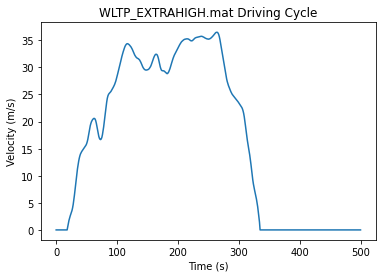

(133717, 20, 4)
(476, 20, 4)


In [73]:
# loading datasets
dc_path = './DrivingCycles/'
dataset_train  = DrivingCyclesDataset(dc_path, train=True)
dataset_test = DrivingCyclesDataset(dc_path, train=False)

# # Plot samples from the test set
# # Europe NEDC 
# sample_data = dataset_train.data[26]
# sample_name = dataset_train.names[26]
# print(sample_data.describe())
# plt.title(sample_name + " Driving Cycle")
# plt.xlabel("Time (s)")
# plt.ylabel("Velocity (m/s)")
# plt.plot(sample_data['T_z'], sample_data['V_z'])
# plt.show()

# # Europe WLTP 
# sample_data = dataset_train.data[37]
# sample_name = dataset_train.names[37]
# print(sample_data.describe())
# plt.title(sample_name + " Driving Cycle")
# plt.xlabel("Time (s)")
# plt.ylabel("Velocity (m/s)")
# plt.plot(sample_data['T_z'], sample_data['V_z'])
# plt.show()

# # Japan 10 Mode 
# sample_data = dataset_train.data[30]
# sample_name = dataset_train.names[30]
# print(sample_data.describe())
# plt.title(sample_name + " Driving Cycle")
# plt.xlabel("Time (s)")
# plt.ylabel("Velocity (m/s)")
# plt.plot(sample_data['T_z'], sample_data['V_z'])
# plt.show()

# # US FTP_75 
# sample_data = dataset_train.data[17]
# sample_name = dataset_train.names[17]
# print(sample_data.describe())
# plt.title(sample_name + " Driving Cycle")
# plt.xlabel("Time (s)")
# plt.ylabel("Velocity (m/s)")
# plt.plot(sample_data['T_z'], sample_data['V_z'])
# plt.show()

# Plot 1 sample from the test set
sample_data = dataset_test.data[0]
sample_name = dataset_test.names[0]
plt.title(sample_name + " Driving Cycle")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.plot(sample_data['T_z'], sample_data['V_z'])
plt.show()

# scaling the datasets 
scaler = MinMaxScaler(feature_range=(0,1))
for df in dataset_train: 
    df['V_z'] = scaler.fit_transform(df[['V_z']])
    # df['D_z'] = scaler.fit_transform(df[['D_z']])
for df in dataset_test: 
    df['V_z'] = scaler.fit_transform(df[['V_z']])
    # df['D_z'] = scaler.fit_transform(df[['D_z']])

# parameters h and f
h = 20 # length of historical sequence
f = 5 # length of forecast sequence 
step = 1

# create training set and test set 
pd.options.mode.chained_assignment = None
x_train, y_train = create_dataset(dataset_train, h, f, step, False)
x_test, y_test = create_dataset(dataset_test, h, f, step, True)

# check 
print(x_train.shape)
print(x_test.shape)

# reshaping input to LSTM model 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

## Step 3: LSTM
In this section we will try to make a LSTM predictor to predict the future velocity. 

### Step 3.1: Define the model. (15 points)

Design a neural network which consists of a number of convolutional layers and a few fully connected ones at the end.

The exact architecture is up to you but you do NOT need to create something complicated. For example, you could design a LeNet insprired network.

In [74]:
# check
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

print(type(x_train))
print(type(y_test))

# Network 
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) # units depends on create_dataset function
model.add(Dropout(0.2))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=f))

print(model.summary())

(133717, 20, 4)
(476, 20, 4)
(133717, 5)
(476,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 20, 100)           42000     
                                                                 
 dropout_20 (Dropout)        (None, 20, 100)           0         
                                                                 
 lstm_21 (LSTM)              (None, 20, 100)           80400     
                                                                 
 dropout_21 (Dropout)        (None, 20, 100)           0         
                                                                 
 lstm_22 (LSTM)              (None, 20, 100)           80400     
                                                                 
 dropout_22 (Dropout)        (None, 20, 100)           0         
                        

### Step 3.2: Define the training parameters. (10 points)

- Loss function
- Optimizer
- Learning Rate
- Number of iterations
- Batch Size
- Other relevant hyperparameters

In [75]:
# compile the model 
model.compile(loss='mse', optimizer='adam')

### Step 3.3: Train the model.

In [76]:
model.fit(x_train, y_train, epochs=10, batch_size=50)
model.save('speed_prediction 3.h5')

# load the model 
model = load_model('speed_prediction 3.h5') 

Epoch 1/10
2675/2675 [==============================] - 595s 208ms/step - loss: 0.0034
Epoch 2/10
2675/2675 [==============================] - 583s 218ms/step - loss: 0.0019
Epoch 3/10
2675/2675 [==============================] - 443s 166ms/step - loss: 0.0012
Epoch 4/10
2675/2675 [==============================] - 533s 199ms/step - loss: 9.3971e-04
Epoch 5/10
2675/2675 [==============================] - 537s 201ms/step - loss: 8.4698e-04
Epoch 6/10
2675/2675 [==============================] - 520s 195ms/step - loss: 7.8087e-04
Epoch 7/10
2675/2675 [==============================] - 486s 182ms/step - loss: 7.5295e-04
Epoch 8/10
2675/2675 [==============================] - 590s 221ms/step - loss: 7.2796e-04
Epoch 9/10
2675/2675 [==============================] - 653s 244ms/step - loss: 6.9929e-04
Epoch 10/10
2675/2675 [==============================] - 481s 180ms/step - loss: 6.8585e-04


### Step 3.4: Deploy the trained model onto the test set. 

In [77]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# check
print(predictions.shape)

(476, 5)


In [78]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))

#check
print(y_test_scaled.shape)

(476, 1)


### Step 3.5: Evaluate the performance of the model 

In [79]:
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss: ", results)

4/4 [==============================] - 14s 164ms/step - loss: 3.0359e-04
test loss:  0.0003035898844245821


### Step 3.6: Visualisation of prediction

Text(0, 0.5, 'Time (s)')

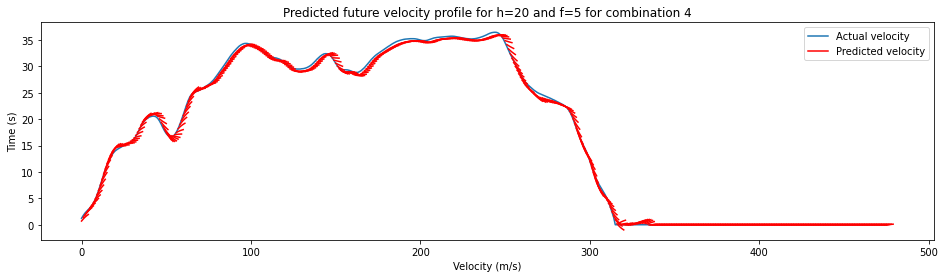

In [80]:
# Combination information
combi = 4

# plotting
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(y_test_scaled)
# plt.plot(predictions, color='red') 
for i in range(predictions.shape[0]): 
    plt.plot(range(i,i+f), predictions[i], color='red') 
plt.legend(['Actual velocity', 'Predicted velocity'])
title = 'Predicted future velocity profile for h=' + str(h) + ' and f=' + str(f) + ' for combination ' + str(combi)
plt.title(title)
plt.xlabel("Velocity (m/s)")
plt.ylabel("Time (s)")

### Step 4: Hyperparameter Search

#### Step 4.1: Early stopping

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)

multi_step_history = model.fit(train_data_multi,
                                epochs=EPOCHS,
                                steps_per_epoch=EVALUATION_INTERVAL,
                                validation_data=val_data_multi,
                                validation_steps=EVALUATION_INTERVAL,
                                callbacks=[early_stopping])

#### Step 4.2: Grid search

In [ ]:
from sklearn.model_selection import GridSearchCV

# define search space 
space = dict()
space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
space['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
space['fit_intercept'] = [True, False]
space['normalize'] = [True, False]

# define search 
search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)

# execute the search
result = search.fit(X, y)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

header = ['nb_epoch', 'batch_size', 'learning_rate','RMSE_error']
with open('output.csv', 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(header)

param_dist = {
    'nb_epoch': [10, 100, 250, 500, 1000], 
    'batch_size': [1000, 2000, 3000, 4000, 5000, 6500], 
    'learning_rate': [0.000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01] 
}
    
best_params = []
min_score = float('inf')
for batch in param_dist['batch_size']:
    for learning_rate in param_dist['learning_rate']:
        for epoch in param_dist['nb_epoch']:

            regressor = Regressor(x_train)
            # Change hyperparameters
            regressor.nb_epoch = epoch
            regressor.batch_size = batch
            regressor.learning_rate = learning_rate
                  
            # Train model
            regressor.fit(x_train, y_train)
            # Validate
            error = regressor.score(x_val, y_val)
            #   print(f"Epochs:, {epoch}, \t Batch Sz:, {batch}, \t learning_rate:, {learning_rate}, \t Score(Absolute Error):, {error}")
            # save data into a csv file 
            row = [epoch, batch, learning_rate, error.item()]
            with open('output.csv', 'a') as csvfile:
                csvwriter = csv.writer(csvfile)
                csvwriter.writerow(row)


            # keep track of minimum score 
            if (error < min_score): 
                min_score = error
                best_params = [epoch, batch, learning_rate]
    
return best_params 

#### Step 4.3: Bayesian optimisation

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import make_scorer, mean_squared_error
from bayes_opt import BayesianOptimization
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# Make scorer accuracy
score_acc = make_scorer(mean_squared_error)

# Create function
def nn_cl_bo2(neurons, activation, optimizer, learning_rate, batch_size, epochs,
              layers1, layers2, normalization, dropout, dropout_rate):
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    optimizerD= {'Adam':Adam(learning_rate=learning_rate), 'SGD':SGD(learning_rate=learning_rate),
                 'RMSprop':RMSprop(learning_rate=learning_rate), 'Adadelta':Adadelta(learning_rate=learning_rate),
                 'Adagrad':Adagrad(learning_rate=learning_rate), 'Adamax':Adamax(learning_rate=learning_rate),
                 'Nadam':Nadam(learning_rate=learning_rate), 'Ftrl':Ftrl(learning_rate=learning_rate)}
    neurons = round(neurons)
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    batch_size = round(batch_size)
    epochs = round(epochs)
    layers1 = round(layers1)
    layers2 = round(layers2)
    def nn_cl_fun():
        model = Sequential()
        model.add(LSTM(units=neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) # units depends on create_dataset function
        for i in range(layers1):
            model.add(LSTM(units=100,return_sequences=True))
        if dropout > 0.5:
            model.add(Dropout(dropout_rate, seed=123))
        for i in range(layers2):
            model.add(LSTM(units=100,return_sequences=True))
        model.add(Dense(units=f))
        model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
        return model
    # es = EarlyStopping(monitor='val_loss', mode='max', verbose=0, patience=20)
    early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
    model = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size, verbose=0)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    model.fit(x_train,y_train,epochs=epochs,validation_data=(x_test,y_test),callbacks=[early_stopping])
    score = model.evaluate(x_test, y_test, batch_size=128)
    return score

# Set paramaters
params_nn2 ={
    'neurons': (10, 100),
    'activation':(0, 9),
    'optimizer':(0,7),
    'learning_rate':(0.01, 1),
    'batch_size':(200, 1000),
    'epochs':(20, 100),
    'layers1':(1,3),
    'layers2':(1,3),
    'normalization':(0,1),
    'dropout':(0,1),
    'dropout_rate':(0,0.3)
}

# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_cl_bo2, params_nn2, random_state=111)
nn_bo.maximize(init_points=25, n_iter=4)

params_nn_ = nn_bo.max['params']
learning_rate = params_nn_['learning_rate']
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU,'relu']
params_nn_['activation'] = activationL[round(params_nn_['activation'])]
params_nn_['batch_size'] = round(params_nn_['batch_size'])
params_nn_['epochs'] = round(params_nn_['epochs'])
params_nn_['layers1'] = round(params_nn_['layers1'])
params_nn_['layers2'] = round(params_nn_['layers2'])
params_nn_['neurons'] = round(params_nn_['neurons'])
optimizerL = ['Adam', 'SGD', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','Adam']
optimizerD= {'Adam':Adam(learning_rate=learning_rate), 'SGD':SGD(learning_rate=learning_rate),
             'RMSprop':RMSprop(learning_rate=learning_rate), 'Adadelta':Adadelta(learning_rate=learning_rate),
             'Adagrad':Adagrad(learning_rate=learning_rate), 'Adamax':Adamax(learning_rate=learning_rate),
             'Nadam':Nadam(learning_rate=learning_rate), 'Ftrl':Ftrl(learning_rate=learning_rate)}
params_nn_['optimizer'] = optimizerD[optimizerL[round(params_nn_['optimizer'])]]
params_nn_

#### Step 4.4: Keras Tuner

In [100]:
# importing libraries
import keras
from keras_tuner import BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameters

# defining model space search
def build_model(hp):
    model = Sequential()
    # tuning number of neurons
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
    # tuning number of layers
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    # dropout layer
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    # dense layer and activation function
    model.add(Dense(y_train.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    return model

# create Tuner object
tuner= BayesianOptimization(
        build_model,
        objective='mse',
        max_trials=2,
        executions_per_trial=1
        )

# hyperparameter search 
early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
tuner.search(x_train, y_train,epochs=5, steps_per_epoch = 100, validation_data = 50,
     #validation_data=(X_test, y_test)
     validation_split=0.2,verbose=1, callbacks=[early_stopping])

# best model
best_model = tuner.get_best_models(num_models=1)[0]
print(best_mode.summary())

# best hyperparameter
best_hyperparameters = tuner.get_best_hyperparameters(num_models=1)[0]
print(best_hyperparameters)

# prediction 
predictions=best_model.predict(x_test)

# saving model 
model.save('bestLSTM.h5')

Trial 2 Complete [03h 28m 03s]
mse: 0.001679309643805027

Best mse So Far: 0.001679309643805027
Total elapsed time: 04h 37m 03s
INFO:tensorflow:Oracle triggered exit


NameError: name 'save_model' is not defined